<h1 style="text-align: center;">Assignment 2</h1>



We start our assignment with loading all the nessesary imports we are going to need. Followed that we have some deffinitions as well as some helpful functions that we are going to use. 

In [4]:
################## imports  ####################################
import urllib.request
import pandas as pd
import json
import os
import networkx as nx
import re
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import nltk
import os
from tqdm.notebook import tqdm
import json
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import RegexpTokenizer
from matplotlib.lines import Line2D
import ast
import nltk 
import nltk, re, pprint
from wordcloud import WordCloud, ImageColorGenerator 
from PIL import Image 
from stop_words import get_stop_words
from nltk.corpus import stopwords
import pprint
from nltk import word_tokenize
import string
import csv
import operator
import numpy.random
import statistics
import powerlaw
import ast
import math
from bs4 import BeautifulSoup
from collections import Counter
# from community import community_louvain
import itertools
from fa2 import ForceAtlas2

import warnings
warnings.filterwarnings("ignore")
###############################################################

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [5]:
################### Global Definitions ########################
dc_unv = "DC"
marvel_unv = "Marvel"
universes = [dc_unv, marvel_unv]
data_folder = "../Data/"
###############################################################

In [6]:
#################### Functions for part 1 ################################

def flatten_and_remove_empty(l):
    return [item for sublist in l for item in sublist if item != '']

def check_if_present_in_links(dc_df, marvel_df, link):
    target = dc_df.loc[dc_df['WikiLink'] == link]
    if not target.empty:
        return str(target['CharacterName'].values[0])
    target = marvel_df.loc[marvel_df['WikiLink'] == link]
    if not target.empty:
        return str(target['CharacterName'].values[0])
    return None

def check_if_present_in_names(dc_df, marvel_df, name):
    target = dc_df.loc[dc_df['CharacterName'] == name]
    if not target.empty:
        return name
    target = marvel_df.loc[marvel_df['CharacterName'] == name]
    if not target.empty:
        return name
    
    return None
    
def get_name_from_link(df, link):
    target = df.loc[df['WikiLink'] == link]
    return target['CharacterName']
    
def get_charactername_from_filename(filename):
    return filename.replace("_*_"," ").replace("-*-","/").replace(".txt","")

def get_filename_from_charactername(character_name):
    return character_name.replace(" ", "_*_").replace("/","-*-")

###############################################################

#################### Functions for Communities ################


def get_wordsListForUniverse(path):
    os.chdir(path)
    # iterate through all file
    Text_all = []
    for file in os.listdir():
        # Check whether file is in text format or not
        if file.endswith(".txt"):
            file_path = f"{path}/{file}"
            f = open(file_path)
            # call read text file function
            text = f.read()

            # get text from html (output is a list)
            raw = BeautifulSoup(text, 'html.parser').get_text()
            tokens = word_tokenize(raw)

            # change the list to a string
            Str = ""
            for i in range(len(tokens)):
                Str = Str + ' ' + tokens[i]

                    # Remove all punctuation from your list of tokens
            text = Str.translate(str.maketrans('', '', string.punctuation))
            # Set everything to lowercase
            text = text.lower()
            # Divide the whole string into words
            tokens = word_tokenize(text)

            # Delete the stopwords in the text
            stop_words = list(get_stop_words('en'))         #Have around 900 stopwords
            nltk_words = list(stopwords.words('english'))   #Have around 150 stopwords
            stop_words.extend(nltk_words)
            tokens_ = []
            for words in tokens:
                if not words in stop_words:
                    tokens_.append(words)

            # Remove the words that too short or too long
            tokens_1 = []
            for i in range(len(tokens_)):
                if 2 < len(tokens_[i]) <15 :
                    tokens_1.append(tokens_[i])

            Text_all.append(tokens_1)

        strAll = []
        for i in range(len(Text_all)):
            strAll += Text_all[i]

    return strAll
    

def get_community_text(communityNameList,path):
    Vaules_Text = []
    for i in range(len(communityNameList)):
        try:
            file = communityNameList[i].replace(" ", "_*_")
            file = file  + '.txt'
            file_path = f"{path}/{file}"
            f = open(file_path)
            text = f.read()
        except:
            pass
        
        # get text from html (output is a list)
        raw = BeautifulSoup(text, 'html.parser').get_text()
        tokens = word_tokenize(raw)
        # change the list to a string
        Str = ""
        for i in range(len(tokens)):
            Str = Str + ' ' + tokens[i]

        # Remove all punctuation from your list of tokens
        text = Str.translate(str.maketrans('', '', string.punctuation))
        # Set everything to lowercase
        text = text.lower()
        # Divide the whole string into words
        tokens = word_tokenize(text)

        # Delete the stopwords in the text
        stop_words = list(get_stop_words('en'))         #Have around 900 stopwords
        nltk_words = list(stopwords.words('english'))   #Have around 150 stopwords
        stop_words.extend(nltk_words)
        tokens_ = []
        for words in tokens:
            if not words in stop_words:
                tokens_.append(words)

        # Remove the words that too short or too long
        tokens_1 = []
        for i in range(len(tokens_)):
            if 2 < len(tokens_[i]) <15 :
                tokens_1.append(tokens_[i])

        Vaules_Text.append(tokens_1)

    return Vaules_Text


def Create_CommunityDict_Name_word(NameList,Vaules_Text):

    test_keys = NameList
    test_values = Vaules_Text
    communityDict_Name_word = Create_dict(NameList, Vaules_Text)

    return communityDict_Name_word

def get_frequencyDict(tokens):
    fdist1 = nltk.FreqDist(tokens)
    # count the frequency of every words
    dict_frequency = dict(fdist1.most_common())
    # Get most common X with dict
    return dict_frequency

def computeTF_bylist(wordlist): 
    tfDict = {}
    bowCount = len(wordlist)
    wordDict = get_frequencyDict(wordlist)
    for word, count in wordDict.items():
        tfDict[word] = format((count/float(bowCount)),'.3%')
         
    tfDict = dict(sorted(tfDict.items(), key=lambda item: item[1], reverse=True)) # sort
    return tfDict

# input: dict, output:dict
def computeTF(wordDict, tokens): 
    tfDict = {}
    bowCount = len(tokens)
    for word, count in wordDict.items():
        tfDict[word] = round((count/float(bowCount)),5)
    tfDict = dict(sorted(tfDict.items(), key=lambda item: item[1], reverse=True)) # sort
    return tfDict

# input: dict, output:dict
def computeIDF(communityDict_Name_word, Community_Allword_tf):
    
    word_count = []
    WordList_withRow = list(communityDict_Name_word.values())
    WordList = dict(Community_Allword_tf.items())

    # Take the largest 1000 words to reduce the calculation time
    Length = len(dict(Community_Allword_tf.items()))
    if Length > 200:
        WordList_less = dict(itertools.islice(WordList.items(), 200))
    else:
        WordList_less = WordList

    for word in WordList_less:
        
        for word in WordList_less:
            count = 0
            for j in range(len(WordList_withRow)):
                if word in WordList_withRow[j]:
                    count += 1
            word_count.append(count)

    DictWords_counts = Create_dict(WordList_less, word_count)
    idfDict = {}
    N = len(WordList_withRow)
    for word, val in DictWords_counts.items():
        idfDict[word] = math.log10(N / float(val))
   
    idfDict = dict(sorted(idfDict.items(), key=lambda item: item[1], reverse=True)) # sorted
    return idfDict


def get_Name_word_frequency(communityDict_Name_word,communityNameList):

    community_TF_list = []
    community_words_list  = []
    community_All_words = []    
    for i in range(len(communityDict_Name_word)):
        ttt = list(communityDict_Name_word.values())[i]
        fdist1 = nltk.FreqDist(ttt)
        word_frequency = fdist1.most_common()

        token = list(communityDict_Name_word.values())[i]
        
        word_tf = computeTF(dict(word_frequency), token)
        community_TF_list.append(list(word_tf.items()))

        community_words_list.append(list(communityDict_Name_word.values())[i])

    # Combine all words from lists in a community
    #################### Functions for part 1 ################################

def flatten_and_remove_empty(l):
    return [item for sublist in l for item in sublist if item != '']

def check_if_present_in_links(dc_df, marvel_df, link):
    target = dc_df.loc[dc_df['WikiLink'] == link]
    if not target.empty:
        return str(target['CharacterName'].values[0])
    target = marvel_df.loc[marvel_df['WikiLink'] == link]
    if not target.empty:
        return str(target['CharacterName'].values[0])
    return None

def check_if_present_in_names(dc_df, marvel_df, name):
    target = dc_df.loc[dc_df['CharacterName'] == name]
    if not target.empty:
        return name
    target = marvel_df.loc[marvel_df['CharacterName'] == name]
    if not target.empty:
        return name
    
    return None
    
def get_name_from_link(df, link):
    target = df.loc[df['WikiLink'] == link]
    return target['CharacterName']
    
def get_charactername_from_filename(filename):
    return filename.replace("_*_"," ").replace("-*-","/").replace(".txt","")

def get_filename_from_charactername(character_name):
    return character_name.replace(" ", "_*_").replace("/","-*-")

###############################################################

#################### Functions for Communities ################


def get_wordsListForUniverse(path):
    os.chdir(path)
    # iterate through all file
    Text_all = []
    for file in os.listdir():
        # Check whether file is in text format or not
        if file.endswith(".txt"):
            file_path = f"{path}/{file}"
            f = open(file_path)
            # call read text file function
            text = f.read()

            # get text from html (output is a list)
            raw = BeautifulSoup(text, 'html.parser').get_text()
            tokens = word_tokenize(raw)

            # change the list to a string
            Str = ""
            for i in range(len(tokens)):
                Str = Str + ' ' + tokens[i]

                    # Remove all punctuation from your list of tokens
            text = Str.translate(str.maketrans('', '', string.punctuation))
            # Set everything to lowercase
            text = text.lower()
            # Divide the whole string into words
            tokens = word_tokenize(text)

            # Delete the stopwords in the text
            stop_words = list(get_stop_words('en'))         #Have around 900 stopwords
            nltk_words = list(stopwords.words('english'))   #Have around 150 stopwords
            stop_words.extend(nltk_words)
            tokens_ = []
            for words in tokens:
                if not words in stop_words:
                    tokens_.append(words)

            # Remove the words that too short or too long
            tokens_1 = []
            for i in range(len(tokens_)):
                if 2 < len(tokens_[i]) <15 :
                    tokens_1.append(tokens_[i])

            Text_all.append(tokens_1)

        strAll = []
        for i in range(len(Text_all)):
            strAll += Text_all[i]

    return strAll
    

def get_community_text(communityNameList,path):
    Vaules_Text = []
    for i in range(len(communityNameList)):
        try:
            file = communityNameList[i].replace(" ", "_*_")
            file = file  + '.txt'
            file_path = f"{path}/{file}"
            f = open(file_path)
            text = f.read()
        except:
            pass
        
        # get text from html (output is a list)
        raw = BeautifulSoup(text, 'html.parser').get_text()
        tokens = word_tokenize(raw)
        # change the list to a string
        Str = ""
        for i in range(len(tokens)):
            Str = Str + ' ' + tokens[i]

        # Remove all punctuation from your list of tokens
        text = Str.translate(str.maketrans('', '', string.punctuation))
        # Set everything to lowercase
        text = text.lower()
        # Divide the whole string into words
        tokens = word_tokenize(text)

        # Delete the stopwords in the text
        stop_words = list(get_stop_words('en'))         #Have around 900 stopwords
        nltk_words = list(stopwords.words('english'))   #Have around 150 stopwords
        stop_words.extend(nltk_words)
        tokens_ = []
        for words in tokens:
            if not words in stop_words:
                tokens_.append(words)

        # Remove the words that too short or too long
        tokens_1 = []
        for i in range(len(tokens_)):
            if 2 < len(tokens_[i]) <15 :
                tokens_1.append(tokens_[i])

        Vaules_Text.append(tokens_1)

    return Vaules_Text


def Create_CommunityDict_Name_word(NameList,Vaules_Text):

    test_keys = NameList
    test_values = Vaules_Text
    communityDict_Name_word = Create_dict(NameList, Vaules_Text)

    return communityDict_Name_word

def get_frequencyDict(tokens):
    fdist1 = nltk.FreqDist(tokens)
    # count the frequency of every words
    dict_frequency = dict(fdist1.most_common())
    # Get most common X with dict
    return dict_frequency

def computeTF_bylist(wordlist): 
    tfDict = {}
    bowCount = len(wordlist)
    wordDict = get_frequencyDict(wordlist)
    for word, count in wordDict.items():
        tfDict[word] = format((count/float(bowCount)),'.3%')
         
    tfDict = dict(sorted(tfDict.items(), key=lambda item: item[1], reverse=True)) # sort
    return tfDict

# input: dict, output:dict
def computeTF(wordDict, tokens): 
    tfDict = {}
    bowCount = len(tokens)
    for word, count in wordDict.items():
        tfDict[word] = round((count/float(bowCount)),5)
    tfDict = dict(sorted(tfDict.items(), key=lambda item: item[1], reverse=True)) # sort
    return tfDict

# input: dict, output:dict
def computeIDF(communityDict_Name_word, Community_Allword_tf):
    
    word_count = []
    WordList_withRow = list(communityDict_Name_word.values())
    WordList = dict(Community_Allword_tf.items())

    # Take the largest 1000 words to reduce the calculation time
    Length = len(dict(Community_Allword_tf.items()))
    if Length > 200:
        WordList_less = dict(itertools.islice(WordList.items(), 200))
    else:
        WordList_less = WordList

    for word in WordList_less:
        
        for word in WordList_less:
            count = 0
            for j in range(len(WordList_withRow)):
                if word in WordList_withRow[j]:
                    count += 1
            word_count.append(count)

    DictWords_counts = Create_dict(WordList_less, word_count)
    idfDict = {}
    N = len(WordList_withRow)
    for word, val in DictWords_counts.items():
        idfDict[word] = math.log10(N / float(val))
   
    idfDict = dict(sorted(idfDict.items(), key=lambda item: item[1], reverse=True)) # sorted
    return idfDict


def get_Name_word_frequency(communityDict_Name_word,communityNameList):

    community_TF_list = []
    community_words_list  = []
    community_All_words = []    
    for i in range(len(communityDict_Name_word)):
        ttt = list(communityDict_Name_word.values())[i]
        fdist1 = nltk.FreqDist(ttt)
        word_frequency = fdist1.most_common()

        token = list(communityDict_Name_word.values())[i]
        
        word_tf = computeTF(dict(word_frequency), token)
        community_TF_list.append(list(word_tf.items()))

        community_words_list.append(list(communityDict_Name_word.values())[i])

    # Combine all words from lists in a community
    for j in range(len(community_words_list)):
        # if j == 6:
        #     print(community_words_list[j])
        community_All_words.extend(community_words_list[j])

    fdist2 = nltk.FreqDist(community_All_words)
    Allword_frequency = fdist2.most_common()

    # tokens_all is a list including all words of the community
    tokens_all = []
    L = list(communityDict_Name_word.values())
    for i in range(len(L)):
        tokens_all.extend(L[i])
    Community_Allword_tf = computeTF(dict(Allword_frequency), tokens_all)

    Name_word_tf = {}
    test_keys = communityNameList
    test_values = community_TF_list
    for key in test_keys:
        for value in test_values:
            Name_word_tf [key] = value
            test_values.remove(value)
            break
    return Name_word_tf, Community_Allword_tf


def computeTFIDF(tfDict, idfDict):
    tf_idf = {}

    if len(tfDict) <= len(idfDict):
        for word, val in tfDict.items():
            tf_idf[word] = val * idfDict[word] + 0.0001

    elif len(tfDict) > len(idfDict):
        for word, val in idfDict.items():
            tf_idf[word] = val * tfDict[word] + 0.0001

    tf_idf = dict(sorted(tf_idf.items(), key=lambda item: item[1], reverse=True))

    return tf_idf
    

def Create_dict(test_keys, test_values):
    Dict_ = {}
    for key in test_keys:
        for value in test_values:
            Dict_ [key] = value
            test_values.remove(value)
            break
    return Dict_ 


# discard disconnected nodes from the network
def check_nodes(G):
    d_out = dict(G.out_degree())
    key0_out = [k for k, v in d_out.items() if v == 0]
    # get the heros'name-list that out-degree is 0

    d_in = dict(G.in_degree())
    key0_in = [k for k, v in d_in.items() if v == 0]
    # get the heros'name-list that in-degree is 0

    nodesDegree_0 = []
    for i in key0_out:
        if i in key0_in:
            nodesDegree_0.append(i)
    G.remove_nodes_from(nodesDegree_0)
    return G

###############################################################)
    for j in range(len(community_words_list)):
        community_All_words += community_words_list[j]

    fdist2 = nltk.FreqDist(community_All_words)
    Allword_frequency = fdist2.most_common()

    # tokens_all is a list including all words of the community
    tokens_all = []
    L = list(communityDict_Name_word.values())
    for i in range(len(L)):
        tokens_all += L[i]
    Community_Allword_tf = computeTF(dict(Allword_frequency), tokens_all)

    Name_word_tf = {}
    test_keys = communityNameList
    test_values = community_TF_list
    for key in test_keys:
        for value in test_values:
            Name_word_tf [key] = value
            test_values.remove(value)
            break
    return Name_word_tf, Community_Allword_tf
    

def Create_dict(test_keys, test_values):
    Dict_ = {}
    for key in test_keys:
        for value in test_values:
            Dict_ [key] = value
            test_values.remove(value)
            break
    return Dict_ 


# discard disconnected nodes from the network
def check_nodes(G):
    d_out = dict(G.out_degree())
    key0_out = [k for k, v in d_out.items() if v == 0]
    # get the heros'name-list that out-degree is 0

    d_in = dict(G.in_degree())
    key0_in = [k for k, v in d_in.items() if v == 0]
    # get the heros'name-list that in-degree is 0

    nodesDegree_0 = []
    for i in key0_out:
        if i in key0_in:
            nodesDegree_0.append(i)
    G.remove_nodes_from(nodesDegree_0)
    return G

###############################################################

# Data

#### This part of the assignment is about collecting and storing the data.

<details>
  <summary>Click to see the Assignment tasks for this chapter</summary>

This assignment will be based on the DC and Marvel superhero dataset you downloaded during the Week 4 exercises. It's important that you work with your own dataset.

You will need the network structure and the page texts to complete the assignment.

To show that you have collected these files, please place your files somewhere that's accessible online (e.g. a github repo or a webpage) and link to your files from your notebook. (We will appreciate it if you store the wiki pages in plain text and the network as an edgelist. )

</details>

Using the DC and Marvel superhero dataset from week 4 and following the instructions from previous weeks, we create and store in a [github](https://github.com/lefteriskat/SocialGraphsAndInteractions2022/tree/main/Assignment2/Data) repo (the repo will become public right after the assignment2 due) the superhero graph and the wikipages. We save the graph as a pickle to make it easier to load. 

In [7]:
# Load Graph
DC_Marvel_Graph = nx.read_gpickle("../Data/graph.gpickle")

#removing isolates
DC_Marvel_Graph.remove_nodes_from(list(nx.isolates(DC_Marvel_Graph)))

# Load Wikipages as a dictionary with key the CharacterName and value the text of the wikipage
with open('../Data/wikipages.txt',encoding="utf8") as f:
    data = f.read()
    
wikipages_text = ast.literal_eval(data)
  

# Basic Stats

<details>
  <summary>Click to see the Assignment tasks for this chapter</summary>

Write a short paragraph describing the network. The paragraph should contain the following information

* The number of nodes and links. 
* The average, median, mode, minimum and maximum value of the network's in-degree.s And of the out-degrees.

We also want the degree distributions and a plot of the network

* Create in- and out-going degree distributions as described in Lecture 5.
* Estimate the slope of the incoming degree distribtion as described in Lecture 5.
* Plot the network using the Force Atlas algorithm as described in Lecture 5.

(Friendly hint: Remember figure captions.)

</details>

In this part of the assignment we will show some basic statistics from the graph including :
* The number of nodes and links. 
* The average, median, mode, minimum and maximum value of the network's in-degree.s 
* The out-degrees.
* A degree distribution plot


In [8]:
def print_statistics(my_graph, name):
    
    in_degrees = np.array([val for node,val in list(my_graph.in_degree())])
    out_degrees = np.array([val for node,val in list(my_graph.out_degree())])
    
    print(f"\nDegree Statistics of the {name}.")
    print("\tIn-Degree Statistics:")
    mode = stats.mode(in_degrees, axis=None, keepdims=False)
    print(f"\t\tAverage = {np.mean(in_degrees):.2f} \n\t\tMedian = {np.median(in_degrees):.2f}\
                            \n\t\tMode={mode[0]} with {mode[1]} occurences\
                            \n\t\tMinimum = {np.min(in_degrees):.2f}\n\t\tMaximum = {np.max(in_degrees):.2f}.")
    print("\n\tOut-Degree Statistics:")
    
    mode = stats.mode(out_degrees, axis=None, keepdims=False)
    print(f"\t\tAverage = {np.mean(out_degrees):.2f}\n\t\tMedian = {np.median(out_degrees):.2f},\
                            \n\t\tMode={mode[0]} with {mode[1]} occurences\
                            \n\t\tMinimum = {np.min(out_degrees):.2f}\n\t\tMaximum = {np.max(out_degrees):.2f}.")

    

print(f"Number of nodes: {DC_Marvel_Graph.number_of_nodes()}")
print(f"Number of edges: {DC_Marvel_Graph.number_of_edges()}")

in_degrees = sorted(list(DC_Marvel_Graph.in_degree()),key=lambda d: d[1], reverse=True)
out_degrees = sorted(list(DC_Marvel_Graph.out_degree()),key=lambda d: d[1], reverse=True)

in_only_degrees = [val for node,val in in_degrees]
out_only_degrees = [val for node,val in out_degrees]


in_degrees_np = np.array(in_only_degrees)
out_degrees_np = np.array(out_only_degrees)

# DC_nodes = (
#     node
#     for node, data
#     in DC_Marvel_Graph.nodes(data=True)
#     if data.get("universe") == "DC"
# )
# DC_subgraph = DC_Marvel_Graph.subgraph(DC_nodes)

# Marvel_nodes = (
#     node
#     for node, data
#     in DC_Marvel_Graph.nodes(data=True)
#     if data.get("universe") == "Marvel"
# )
# Marvel_subgraph = DC_Marvel_Graph.subgraph(Marvel_nodes)


print_statistics(DC_Marvel_Graph, "DC - Marvel Network")

# print_statistics(DC_subgraph, "DC Network")

# print_statistics(Marvel_subgraph, "Marvel Network")


Number of nodes: 2094
Number of edges: 30869

Degree Statistics of the DC - Marvel Network.
	In-Degree Statistics:
		Average = 14.74 
		Median = 6.00                            
		Mode=0 with 214 occurences                            
		Minimum = 0.00
		Maximum = 467.00.

	Out-Degree Statistics:
		Average = 14.74
		Median = 10.00,                            
		Mode=0 with 411 occurences                            
		Minimum = 0.00
		Maximum = 128.00.


#### Basic statistics of the network

So our network consists of 2094 nodes and 30869 edges and the average degree of each node is 14.74.

About the incoming degree statistics, we can see that even though the average degree is 13.5 the median is only 6 whereas the maximum value is 467. This is an indication that the strong majority of the characters have very few incoming references while there are some very popular characters-hubs that  outperform all the others in terms of incoming references. We can also observe that there are 214 characters with no incoming references.

Regarding the outgoing degree statistics our first observation is the 411 nodes with 0 outgoing references. This may has to do with the construction of the network where we did not check for re-directs in the absence of a page. The median value is 10.00 and the maximum value is 128. It is expected to have a much lower maximum degree than in the incoming degree since a page may be referenced infinite other pages but an individual page cannot include infinite referencdes because of the size limitation. Furthermore, the distribution again is not balanced since half of the nodes have less or equal to 10.00 outgoing references whereas the maximum degree is 128. In the Out-degree the Median number is higher than in the In-Degree despite the fact that we have a significant lower maximum value.

We will explore more about the degree distributions afterwards.

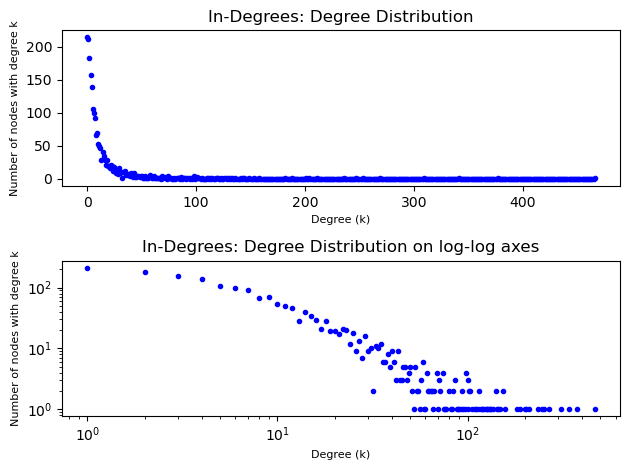

In [9]:
def plot_degree_distribution(degrees, title, color):
    counts, limits = np.histogram(degrees, degrees[0])

    x = limits[:len(counts)]
    y = counts

    ax1 = plt.subplot(2, 1, 1)
    ax1.plot(x, y, color)
    ax1.set_title(title)
    ax1.set_ylabel('Number of nodes with degree k',fontsize=8)
    ax1.set_xlabel('Degree (k)',fontsize=8)

    ax2 =plt.subplot(2, 1, 2)
    ax2.loglog(x, y, color)
    ax2.set_title(title + ' on log-log axes')
    ax2.set_ylabel('Number of nodes with degree k',fontsize=8)
    ax2.set_xlabel('Degree (k)',fontsize=8 )

    plt.tight_layout()
    plt.show()
    
    

plot_degree_distribution(in_only_degrees, "In-Degrees: Degree Distribution", 'b.')

plot_degree_distribution(out_only_degrees, "Out-Degrees: Degree Distribution", 'c.')

As was seen above, a metric as basic as the degree distribution can provide insight into a network's structure and help distinguish between various network types. The degree distribution obviously represents just a small portion of the network structure because it ignores the connections between the nodes. Thus, we can observe here the difference between the In and Out Distribution plot where everything that we we saw in the basic statistics depicts also here in these plots

In [10]:
import powerlaw 

in_degrees = np.array([val for node,val in list(DC_Marvel_Graph.in_degree())])
out_degrees = np.array([val for node,val in list(DC_Marvel_Graph.out_degree())])
    
fit = powerlaw.Fit(in_degrees)

print(f"In Degrees slope = {fit.alpha:.2f}")

fit = powerlaw.Fit(out_degrees)

print(f"Out degrees slope = {fit.alpha:.2f}")

Calculating best minimal value for power law fit
In Degrees slope = 2.54
Calculating best minimal value for power law fit
Out degrees slope = 3.48


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Here a comment about the slope.
2 < gamma < 3 belongs to ultra small world

gamma > 3 more close to a random network

In [11]:
maxcc = max(nx.weakly_connected_components(DC_Marvel_Graph), key=len)

GCC = DC_Marvel_Graph.subgraph(maxcc)

print("Number of Nodes of Largest Connected Component = {}".format(GCC.number_of_nodes()))
print("Number of Edges of Largest Connected Component = {}".format(GCC.number_of_edges()))

Number of Nodes of Largest Connected Component = 2090
Number of Edges of Largest Connected Component = 30866


In [12]:
GCC_undirected = GCC.to_undirected()

print("Number of edges after converting to undirected = {}".format(GCC_undirected.number_of_edges()))

Number of edges after converting to undirected = 26800


After converting the Graph to undirected we see that we miss about 4,000 edges. This means that 4000 connections between nodes were bidirectional.

100%|██████████| 2000/2000 [01:35<00:00, 21.03it/s]


BarnesHut Approximation  took  17.72  seconds
Repulsion forces  took  74.34  seconds
Gravitational forces  took  0.24  seconds
Attraction forces  took  0.76  seconds
AdjustSpeedAndApplyForces step  took  1.04  seconds


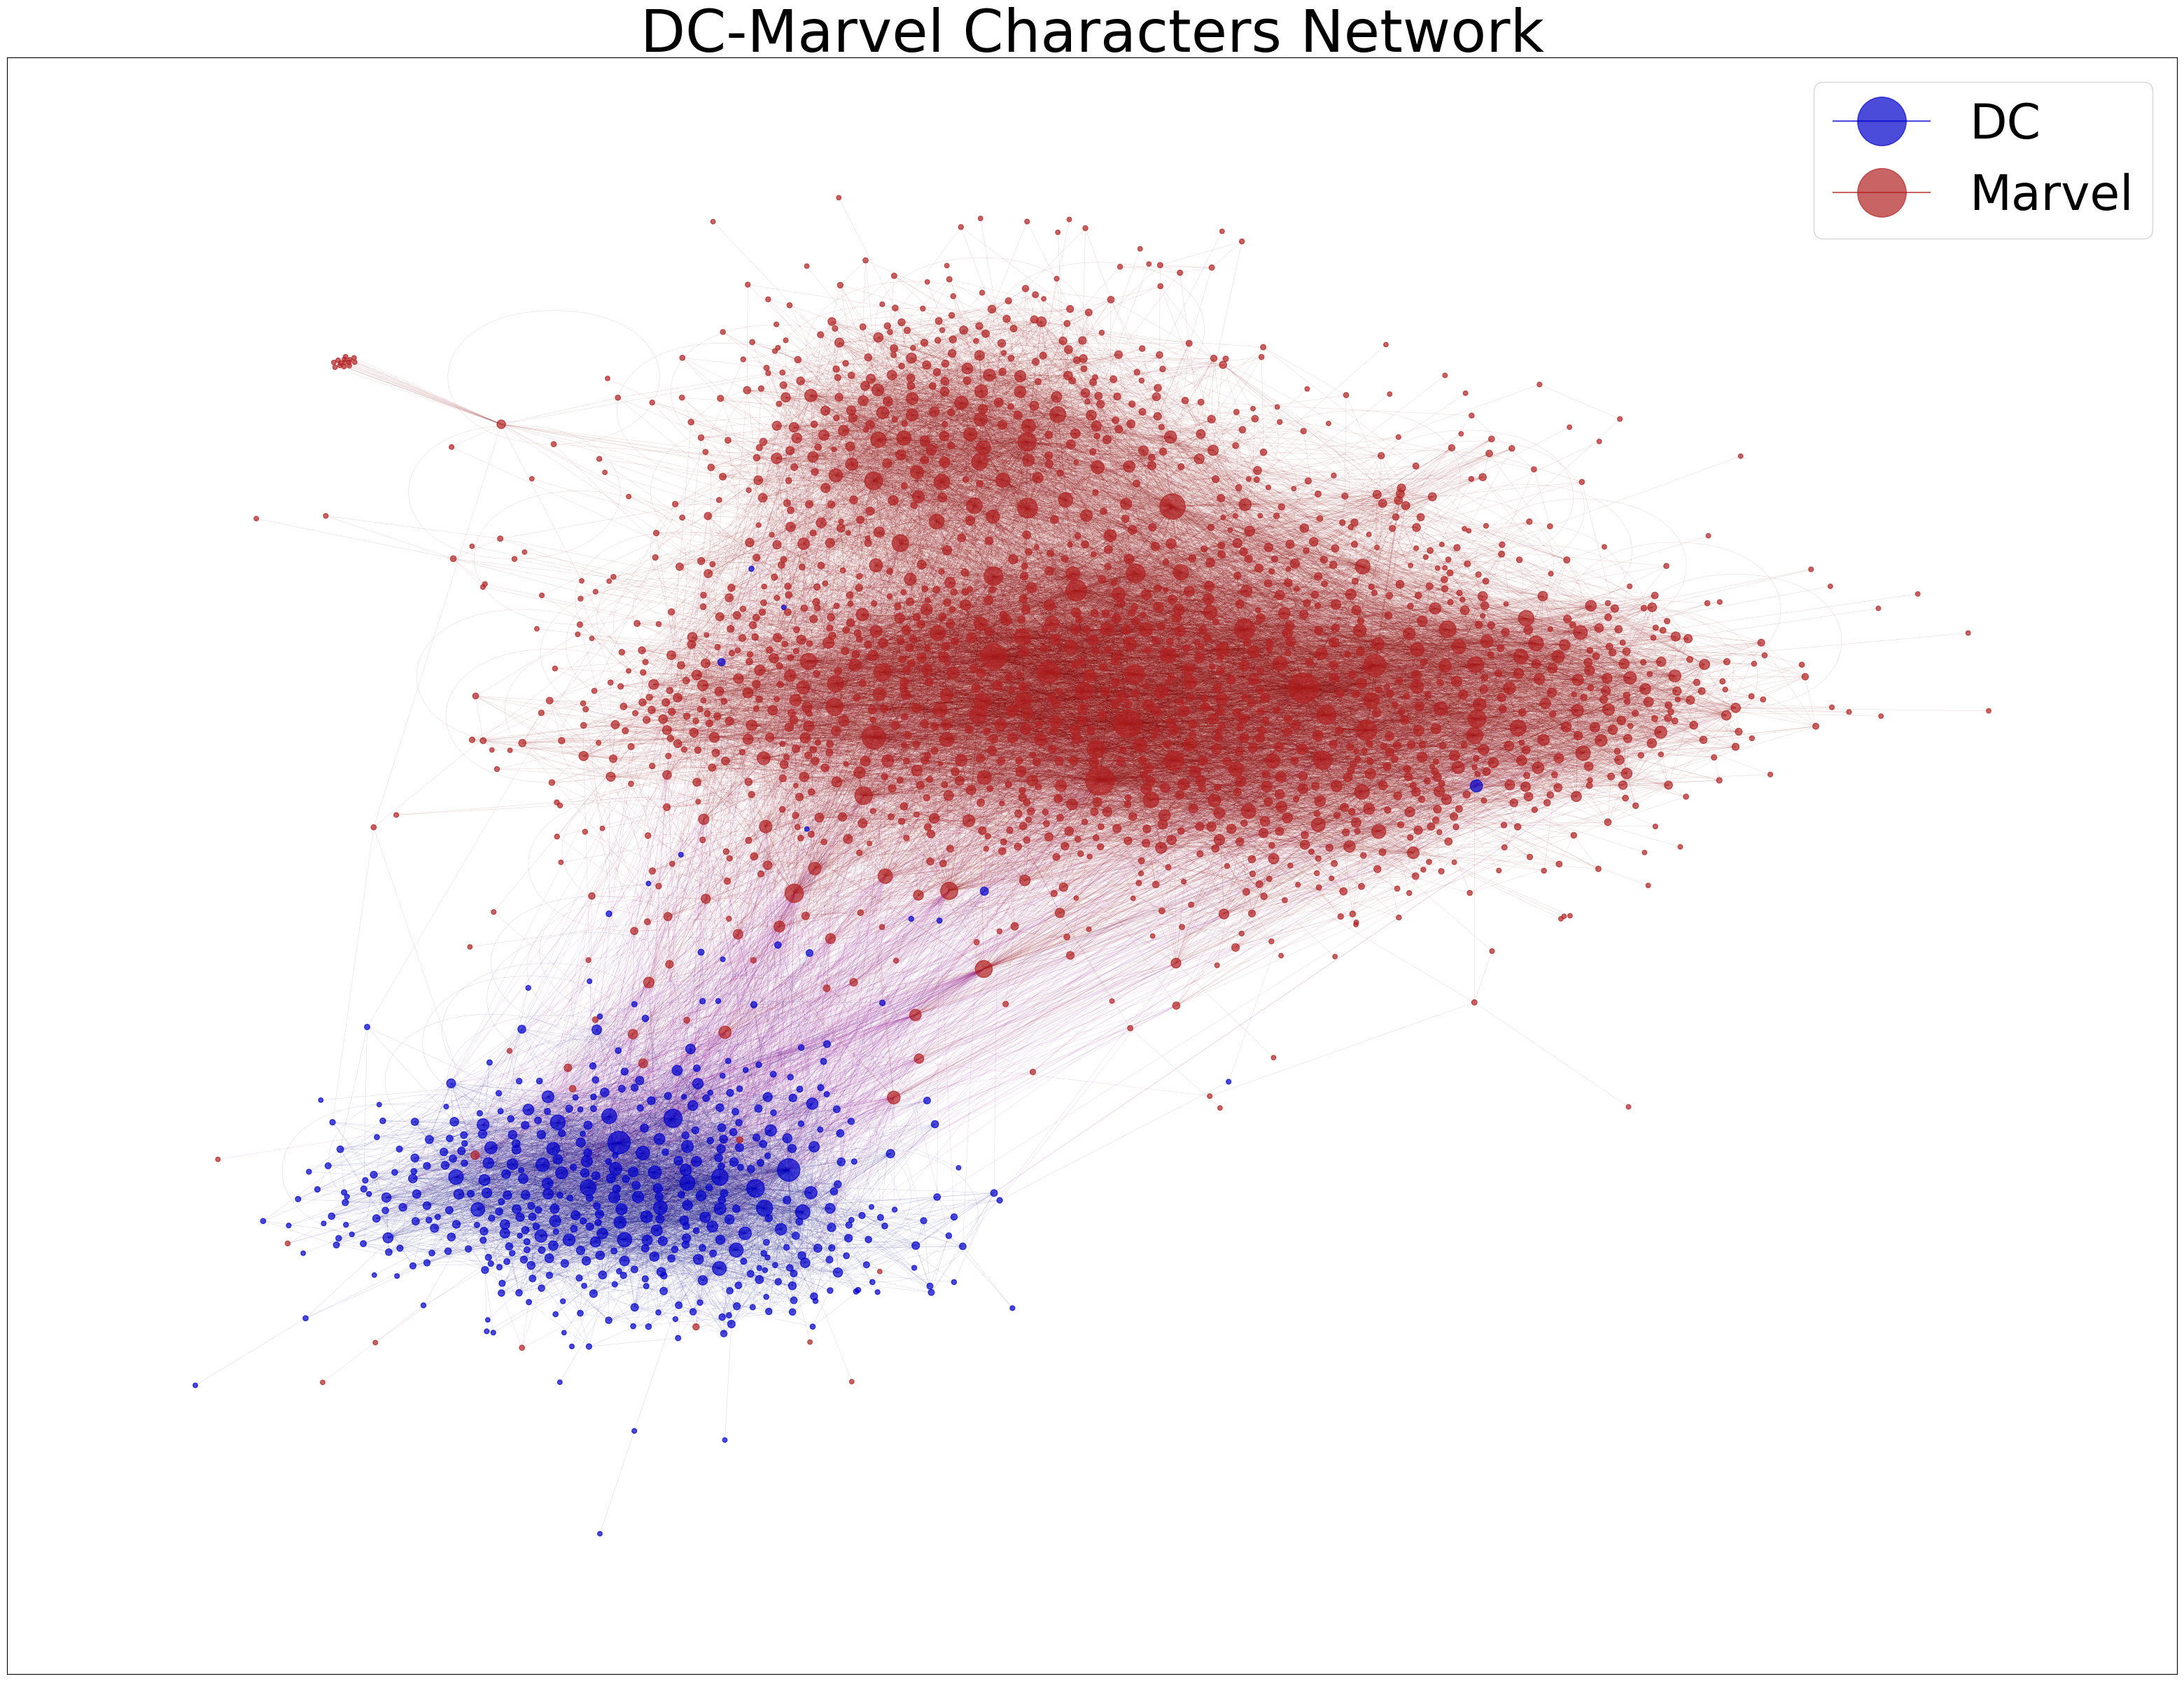

In [12]:
from fa2 import ForceAtlas2

node_sizes = [val*2+20 for node, val in GCC_undirected.degree()]
node_colors = ['#0000CD' if node[1]['universe'] == "DC" else '#B22222' for node in GCC_undirected.nodes(data=True)]
edge_colors = ['#000080' if GCC_undirected.nodes[node1]['universe'] == GCC_undirected.nodes[node2]['universe'] == "DC"\
               else '#8B0000' if GCC_undirected.nodes[node1]['universe'] == GCC_undirected.nodes[node2]['universe'] == "Marvel" \
               else '#8B008B' for node1,node2 in GCC_undirected.edges]

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.0,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=1.0,
                        strongGravityMode=False,
                        gravity=-1,

                        # Log
                        verbose=True)

# plt.figure(figsize=(25,25))
# ax = plt.gca()
# ax.set_title('DC-Marvel Characters Network',fontsize = 40) 
args = {
'node_color': node_colors,
'edge_color':edge_colors,
'node_size':node_sizes,
'width':0.3,
'linewidths':0.3,
}

figure = plt.figure(figsize=(40,30))
# plt.savefig(figure, dpi=1200)
ax = plt.gca()
ax.set_title('DC-Marvel Characters Network',fontsize = 60) 

positions = forceatlas2.forceatlas2_networkx_layout(GCC_undirected, pos=None, iterations=2000)
#nx.draw(GCC_undirected,positions, **args, ax=ax)

nx.draw_networkx_nodes(
    G = GCC_undirected,
    node_size = node_sizes,
    pos = positions, 
    node_color = node_colors,
    alpha = 0.7
)
nx.draw_networkx_edges(
    G = GCC_undirected,
    pos = positions, 
    edge_color = edge_colors, 
    alpha = 0.2,
    width = 0.3
    #linewidths=0.3
)

legends = [Line2D([0], [0], marker='o', color='#0000CD', label= "DC", markersize=50, alpha=0.7),
          Line2D([0], [0], marker='o', color='#B22222', label= "Marvel", markersize=50, alpha=0.7)]
plt.legend(handles = legends, loc = 1, fontsize = 50)
plt.show()

plt.show()

From the plot above we can easily observe that the DC characters are way less that the ones of marvel. The graph seems to be splitted into 2 big clusters and the one of them into 2 smaller subclusters, one with the DC characters and two for the ones belog to MARVEL. We believe that the reason behind this two clusters incide marvels universe is that Marvel, which was in financial trouble following the economic and critical failure of Howard the Duck, decided to sell the film rights to some of its most well-known creations, including the X-Men and The Fantastic Four. Marvel Entertainment, now known as Marvel Studios, was acquired by Disney in 2008 after several failed attempts to find a distributor for its films. Despite this, other companies (mainly 20th Century Fox and Columbia Pictures) still held the movie rights to the majority of Marvel characters, and the merger had no impact on any existing film deals. As a result, some of the most popular Marvel movie franchises, such as the X-Men movie series are completely separate from the MCU. This maybe the reason behind the two clusters inside MARVEL. We can also see many nodes of MARVEL with high-degrees while there are also some but not many in DC. 

# Communities


<details>
  <summary>Click to see the Assignment tasks for this chapter</summary>

Identify the communities in one or both of the superhero universes (DC/Marvel) as described in Week 7.

Visualize the communities by coloring the graph's nodes according to community affiliation - also as described in Week 7.

Write a paragraph about your work to identify the communities. The paragraph should include

* Information about the algorithm you used to find communities.
* The value of modularity for your network.
* The number of communities and their sizes (in terms of number of nodes).

For the 10 largest communities, process the text in order to create a TF-IDF vector for each community. Explain in your own words how TF-IDF works.

Then visualize the TF-IDF vectors using wordclouds (as described in Week 7). Remember to comment on your word-clouds (e.g. in the figure captions): Do the wordclouds/TF-IDF lists enable you to understand the communities you have found (or is it just gibberish)? Justify your answer.

</details>


This part of the assignment is deticated to Comminities. We start again with gothering all the data needed.

In [13]:
# Get Marvel networtx
DC_Marvel_Graph = nx.read_gpickle("../Data/graph.gpickle")
GM = DC_Marvel_Graph
MnodeList = list(GM.nodes(data=True))
# Delete = []
for nodeWithDate in MnodeList:
    if nodeWithDate[1]['universe'] == 'DC':
        GM.remove_node(nodeWithDate[0])

# Get DC networtx
DC_Marvel_Graph = nx.read_gpickle("../Data/graph.gpickle")
GD = DC_Marvel_Graph
DCnodeList = list(GD.nodes(data=True))
# Delete = []
for nodeWithDate in DCnodeList:
    if nodeWithDate[1]['universe'] == 'Marvel':
        GD.remove_node(nodeWithDate[0])

# # discard disconnected nodes from the network
GD = check_nodes(GD)
GM = check_nodes(GM)

#### Identify the communities in  both of the superhero universes (DC/Marvel) 


In [14]:
wordsList_M = list(np.load('../Data/wordsList_M.npy', allow_pickle= True))
wordsList_D = list(np.load('../Data/wordsList_D.npy', allow_pickle= True))

In [17]:
tfM = computeTF_bylist(wordsList_M)
tfM = list(tfM.items())[:15]
tfD = computeTF_bylist(wordsList_D)
tfD = list(tfD.items())[:15]

GM_un = nx.to_undirected(GM)
GD_un = nx.to_undirected(GD)

print(f'The 15 most frequently occurring words and their TFs in Marvel: \n {tfM}\n')
print(f'The 15 most frequently occurring words and their TFs in DC: \n {tfD}')

partitionM = community_louvain.best_partition(GM_un)
partitionD = community_louvain.best_partition(GD_un)

The 15 most frequently occurring words and their TFs in Marvel: 
 [('comics', '2.183%'), ('marvel', '2.046%'), ('cite', '0.633%'), ('category', '0.606%'), ('spiderman', '0.603%'), ('avengers', '0.547%'), ('character', '0.509%'), ('new', '0.481%'), ('xmen', '0.453%'), ('vol', '0.413%'), ('characters', '0.397%'), ('man', '0.376%'), ('comic', '0.345%'), ('series', '0.321%'), ('later', '0.307%')]

The 15 most frequently occurring words and their TFs in DC: 
 [('comics', '1.797%'), ('batman', '0.669%'), ('superman', '0.657%'), ('category', '0.615%'), ('cite', '0.544%'), ('series', '0.504%'), ('justice', '0.500%'), ('new', '0.472%'), ('character', '0.458%'), ('characters', '0.434%'), ('league', '0.434%'), ('vol', '0.391%'), ('ref', '0.348%'), ('comic', '0.336%'), ('first', '0.323%')]


#### Visualize the communities by coloring the graph's nodes according to community affiliation

In [66]:
# We chose the Marvel universe to continue our research below
from community import community_louvain

# plot network
fig, ax = plt.subplots(figsize=(22, 15))

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.0,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=1.0,
                        strongGravityMode=False,
                        gravity=-1,

                        # Log
                        verbose=True)

pos = forceatlas2.forceatlas2_networkx_layout(GM_un, pos=None, iterations=400)

# create a random RMG-color list
import seaborn as sns
P = sns.color_palette("colorblind", 100).as_hex()

#drawing
size = float(len(set(partitionM.values())))

count = 0.
for com in set(partitionM.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partitionM.keys()
                                if partitionM[nodes] == com]
    nx.draw_networkx_nodes(GM_un, pos, list_nodes,alpha = 0.7 ,node_size = 20, 
                                node_color=P[int(count)])



nx.draw_networkx_edges(GM_un, pos, alpha=0.2, edge_color = 'grey')

plt.title('Marvel communities graph.', pad=-14)

plt.show()

100%|██████████| 400/400 [00:15<00:00, 26.52it/s]


BarnesHut Approximation  took  2.58  seconds
Repulsion forces  took  12.02  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.12  seconds
AdjustSpeedAndApplyForces step  took  0.18  seconds


It is natural in this plot to have outliers, but if we exclude those parts and take a closer look at the central graph, we can clearly see how the communities are connected.

#### Our work to identify the communities

We used 'community_louvain.best_partition' to create communites. Its internal principles come from Louvain method.

The Louvain method generally consists of two steps. To create communities, grab nodes in denser areas of the network. Next, Defining a network from the communities found in step 1. The above two steps are repeated until no further reassignments of communities are possible. 

Generally, communities are clusters of nodes in a network that have a more dense connection than other nodes. Using modularity is to measure the quality of nodes, by evaluating how closely connected the nodes are to other nodes. 

In [19]:
x = dict(Counter(partitionM.values()))
count = dict(sorted(x.items(), key=lambda item: item[1], reverse=True))
sorted_M = dict(sorted(x.items(), key=lambda item: item[1], reverse=True)[:10])
# Keys are the order number of the community
# values are the number of nodes
communityNumber = list(sorted_M.keys())
print(f"By best_partition of Louvain method, we get the number of communities of Marvel is {len(count)}")
print(f"The number of nodes in top 10 largest Marvel communities are {list(sorted_M.values())}\n")

xD = dict(Counter(partitionD.values()))
countD = dict(sorted(xD.items(), key=lambda item: item[1], reverse=True))
sorted_D = dict(sorted(xD.items(), key=lambda item: item[1], reverse=True)[:10])
# Keys are the order number of the community
# values are the number of nodes
communityNumber = list(sorted_D.keys())
print(f"By best_partition of Louvain method, we get the number of communities of DC is {len(countD)}")
print(f"The number of nodes in top 9 largest DC communities are {list(sorted_D.values())}")

By best_partition of Louvain method, we get the number of communities of Marvel is 12
The number of nodes in top 10 largest Marvel communities are [442, 432, 383, 139, 124, 53, 23, 11, 10, 2]

By best_partition of Louvain method, we get the number of communities of DC is 10
The number of nodes in top 9 largest DC communities are [94, 72, 70, 57, 43, 38, 27, 24, 23, 12]


In [30]:
communityNameList1, communityNameList2, communityNameList3, communityNameList4, communityNameList5, communityNameList6, communityNameList7, communityNameList8, communityNameList9, communityNameList10,  = ([] for i in range(10))

partition = partitionM
# Create 10 community Name List including all the hero names of each community
for i in range(len(partition)):
    if list(partition.values())[i] == communityNumber[0]:
        communityNameList1.append(list(partition.keys())[i])
    elif list(partition.values())[i] == communityNumber[1]:
        communityNameList2.append(list(partition.keys())[i])
    elif list(partition.values())[i] == communityNumber[2]:
        communityNameList3.append(list(partition.keys())[i])
    elif list(partition.values())[i] == communityNumber[3]:
        communityNameList4.append(list(partition.keys())[i])
    elif list(partition.values())[i] == communityNumber[4]:
        communityNameList5.append(list(partition.keys())[i])
    elif list(partition.values())[i] == communityNumber[5]:
        communityNameList6.append(list(partition.keys())[i])
    elif list(partition.values())[i] == communityNumber[6]:
        communityNameList7.append(list(partition.keys())[i])
    elif list(partition.values())[i] == communityNumber[7]:
        communityNameList8.append(list(partition.keys())[i])
    elif list(partition.values())[i] == communityNumber[8]:
        communityNameList9.append(list(partition.keys())[i])
    elif list(partition.values())[i] == communityNumber[9]:
        communityNameList10.append(list(partition.keys())[i])

In [31]:
# Load the list for heros and their wikipage words in each community

Vaules_Text1 = list(np.load('../Data/arr_Vaules_Text1.npy', allow_pickle= True))
Vaules_Text2 = list(np.load('../Data/arr_Vaules_Text2.npy', allow_pickle= True))
Vaules_Text3 = list(np.load('../Data/arr_Vaules_Text3.npy', allow_pickle= True))
Vaules_Text4 = list(np.load('../Data/arr_Vaules_Text4.npy', allow_pickle= True))
Vaules_Text5 = list(np.load('../Data/arr_Vaules_Text5.npy', allow_pickle= True))
Vaules_Text6 = list(np.load('../Data/arr_Vaules_Text6.npy', allow_pickle= True))
Vaules_Text7 = list(np.load('../Data/arr_Vaules_Text7.npy', allow_pickle= True))
Vaules_Text8 = list(np.load('../Data/arr_Vaules_Text8.npy', allow_pickle= True))
Vaules_Text9 = list(np.load('../Data/arr_Vaules_Text9.npy', allow_pickle= True))
Vaules_Text10 = list(np.load('../Data/arr_Vaules_Text10.npy', allow_pickle= True))

In [32]:
# Get a Dictionary that keys are hero names of each community, values are important words in their wikipages.
communityDict_Name_word1,communityDict_Name_word2,communityDict_Name_word3,communityDict_Name_word4,communityDict_Name_word5,communityDict_Name_word6,communityDict_Name_word7,communityDict_Name_word8,communityDict_Name_word9,communityDict_Name_word10 = (
    Create_CommunityDict_Name_word(communityNameList1,Vaules_Text1),
    Create_CommunityDict_Name_word(communityNameList2,Vaules_Text2),
    Create_CommunityDict_Name_word(communityNameList3,Vaules_Text3),
    Create_CommunityDict_Name_word(communityNameList4,Vaules_Text4),
    Create_CommunityDict_Name_word(communityNameList5,Vaules_Text5),
    Create_CommunityDict_Name_word(communityNameList6,Vaules_Text6),
    Create_CommunityDict_Name_word(communityNameList7,Vaules_Text7),
    Create_CommunityDict_Name_word(communityNameList8,Vaules_Text8),
    Create_CommunityDict_Name_word(communityNameList9,Vaules_Text9),
    Create_CommunityDict_Name_word(communityNameList10,Vaules_Text10)
    )

In [49]:
# Dict_tf: [[Hero, {keys - works in one hero page ; values - TF}],[...],...,[...]]
# Community_Allword_tf:  keys - works   ;   values - TF
Dict_tf1, Community_Allword_tf1 = get_Name_word_frequency(communityDict_Name_word1,communityNameList1)
Dict_tf2, Community_Allword_tf2 = get_Name_word_frequency(communityDict_Name_word2,communityNameList2)
Dict_tf3, Community_Allword_tf3 = get_Name_word_frequency(communityDict_Name_word3,communityNameList3)
Dict_tf4, Community_Allword_tf4 = get_Name_word_frequency(communityDict_Name_word4,communityNameList4)
Dict_tf5, Community_Allword_tf5 = get_Name_word_frequency(communityDict_Name_word5,communityNameList5)
Dict_tf6, Community_Allword_tf6 = get_Name_word_frequency(communityDict_Name_word6,communityNameList6)
Dict_tf7, Community_Allword_tf7 = get_Name_word_frequency(communityDict_Name_word7,communityNameList7)
Dict_tf8, Community_Allword_tf8 = get_Name_word_frequency(communityDict_Name_word8,communityNameList8)
Dict_tf9, Community_Allword_tf9 = get_Name_word_frequency(communityDict_Name_word9,communityNameList9)
Dict_tf10, Community_Allword_tf10 = get_Name_word_frequency(communityDict_Name_word10,communityNameList10)

In [50]:
# keys - words ; values - IDF
idfDict1,idfDict2,idfDict3,idfDict4,idfDict5,idfDict6,idfDict7,idfDict8,idfDict9, idfDict10 = (
    computeIDF(communityDict_Name_word1, Community_Allword_tf1),
    computeIDF(communityDict_Name_word2, Community_Allword_tf2),
    computeIDF(communityDict_Name_word3, Community_Allword_tf3),
    computeIDF(communityDict_Name_word4, Community_Allword_tf4),
    computeIDF(communityDict_Name_word5, Community_Allword_tf5),
    computeIDF(communityDict_Name_word6, Community_Allword_tf6),
    computeIDF(communityDict_Name_word7, Community_Allword_tf7),
    computeIDF(communityDict_Name_word8, Community_Allword_tf8),
    computeIDF(communityDict_Name_word9, Community_Allword_tf9),
    computeIDF(communityDict_Name_word10, Community_Allword_tf10)
)

In [59]:
# keys -  words; values - TF_IDF
tf_idf1, tf_idf2, tf_idf3, tf_idf4, tf_idf5, tf_idf6, tf_idf7, tf_idf8, tf_idf9, tf_idf10  =  (
    computeTFIDF(Community_Allword_tf1, idfDict1), 
    computeTFIDF(Community_Allword_tf2, idfDict2), 
    computeTFIDF(Community_Allword_tf3, idfDict3), 
    computeTFIDF(Community_Allword_tf4, idfDict4),
    computeTFIDF(Community_Allword_tf5, idfDict5),
    computeTFIDF(Community_Allword_tf6, idfDict6),
    computeTFIDF(Community_Allword_tf7, idfDict7),
    computeTFIDF(Community_Allword_tf8, idfDict8),
    computeTFIDF(Community_Allword_tf9, idfDict9),
    computeTFIDF(Community_Allword_tf10, idfDict10))

In [60]:
print(f"The largest 15 words with TF in community one are:\n{list(Community_Allword_tf1.keys())[:15]}\n")

idfDict1_reverse = dict(sorted(idfDict1.items(), key=lambda item: item[1], reverse=False))
print(f"The smallest 15 words with IDF in community one are:\n{list(idfDict1_reverse.keys())[:15]}\n")

print(f"The largest 15 words with TF-IDF in community one are:\n{list(tf_idf1.keys())[:15]}")

The largest 15 words with TF in community one are:
['comics', 'marvel', 'cyclone', 'spiderman', 'batwing', 'avengers', 'jimmy', 'category', 'thunderbolts', 'characters', 'initiative', 'academy', 'created', 'new', 'untold']

The smallest 15 words with IDF in community one are:
['comics', 'marvel', 'spiderman', 'avengers', 'category', 'characters', 'created', 'new', 'fictional', 'later', 'http', 'character', 'first', 'appeared', 'like']

The largest 15 words with TF-IDF in community one are:
['cyclone', 'batwing', 'jimmy', 'thunderbolts', 'initiative', 'academy', 'untold', 'hammer', 'tales', 'randolph', 'maggia', 'punisher', 'mother', 'hood', 'costume']


According definition, the value of TF is proportional to how often a word appears. So TF can show the frequency of each word, but without taking into account the specificity of each word. 
IDF is inversely proportional to how often the word appears in all documents. When the IDF value of a word is closer to 0, the word is more universal, and the specificity of it is lower. 
TF-IDF is the product of the two of the. It comprehensively considers the frequency and particularity of words. it is relatively reasonable to the find wordcould for each individual document.

The example above shows words with the largest 15 words with TF, TF-IDF, and the smallest 15 words with IDF. We can see that the words with higher TF values and less IDF, like 'comics', 'category', values didn't appear on the top ten most TF-IDF words.


#### Wordclouds

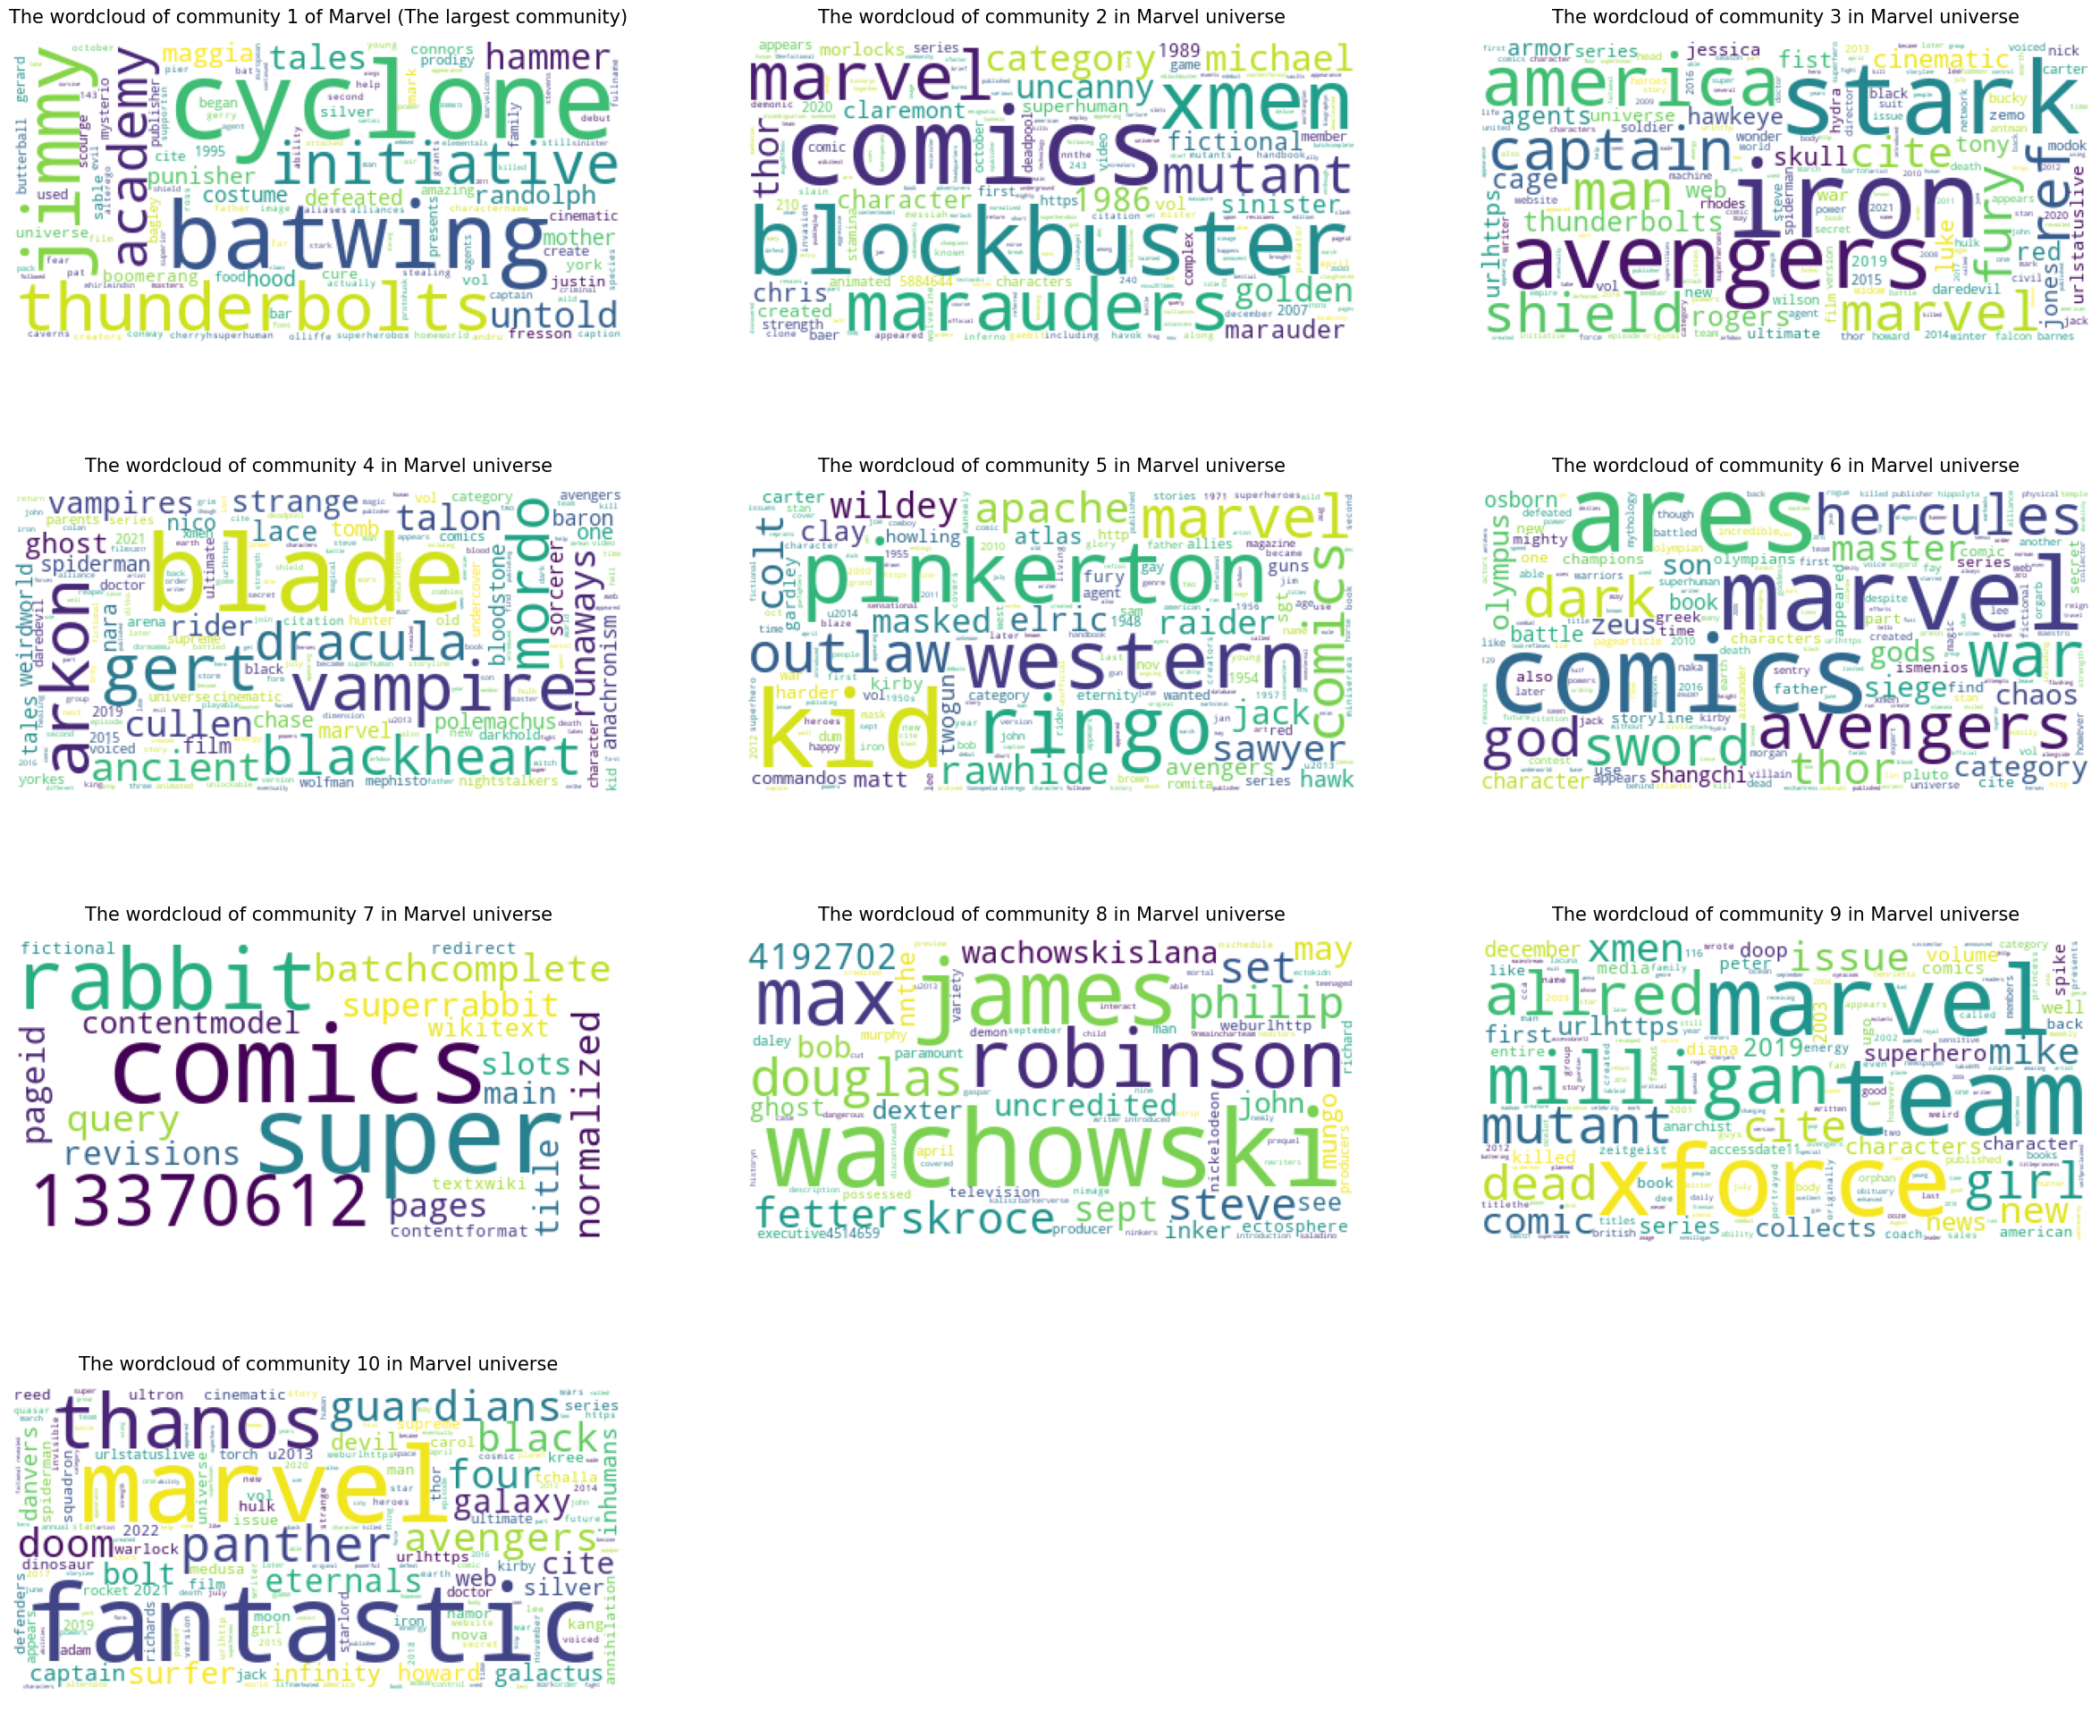

In [62]:
(wordcloud1,wordcloud2,wordcloud3,wordcloud4,wordcloud5,
wordcloud6,wordcloud7,wordcloud8,wordcloud9,wordcloud10) = ( WordCloud(background_color='white',max_font_size = 70) for i in range(10) )

wordcloud1.generate_from_frequencies(frequencies=tf_idf1) 
wordcloud2.generate_from_frequencies(frequencies=tf_idf2)
wordcloud3.generate_from_frequencies(frequencies=tf_idf3)
wordcloud4.generate_from_frequencies(frequencies=tf_idf4)
wordcloud5.generate_from_frequencies(frequencies=tf_idf5)
wordcloud6.generate_from_frequencies(frequencies=tf_idf6)
wordcloud7.generate_from_frequencies(frequencies=tf_idf7)
wordcloud8.generate_from_frequencies(frequencies=tf_idf8)
wordcloud9.generate_from_frequencies(frequencies=tf_idf9)
wordcloud10.generate_from_frequencies(frequencies=tf_idf10)

fig, axs = plt.subplots(nrows=4, ncols = 3, figsize = (30, 25))

axs[0, 0].imshow(wordcloud1)
axs[0, 0].set_title('The wordcloud of community 1 of Marvel (The largest community)', fontsize = 15, pad=14)
axs[0, 0].axis("off")

axs[0, 1].imshow(wordcloud2)
axs[0, 1].set_title('The wordcloud of community 2 in Marvel universe',fontsize = 15, pad=14)
axs[0, 1].axis("off")

axs[0, 2].imshow(wordcloud3)
axs[0, 2].set_title('The wordcloud of community 3 in Marvel universe',fontsize = 15, pad=14)
axs[0, 2].axis("off")

axs[1, 0].imshow(wordcloud4)
axs[1, 0].set_title('The wordcloud of community 4 in Marvel universe',fontsize = 15, pad=14)
axs[1, 0].axis("off")

axs[1, 1].imshow(wordcloud5)
axs[1, 1].set_title('The wordcloud of community 5 in Marvel universe',fontsize = 15, pad=14)
axs[1, 1].axis("off")

axs[1, 2].imshow(wordcloud6)
axs[1, 2].set_title('The wordcloud of community 6 in Marvel universe',fontsize = 15, pad=14)
axs[1, 2].axis("off")

axs[2, 0].imshow(wordcloud7)
axs[2, 0].set_title('The wordcloud of community 7 in Marvel universe',fontsize = 15, pad=14)
axs[2, 0].axis("off")

axs[2, 1].imshow(wordcloud8)
axs[2, 1].set_title('The wordcloud of community 8 in Marvel universe',fontsize = 15, pad=14)
axs[2, 1].axis("off")

axs[2, 2].imshow(wordcloud9)
axs[2, 2].set_title('The wordcloud of community 9 in Marvel universe',fontsize = 15, pad=14)
axs[2, 2].axis("off")

axs[3, 0].imshow(wordcloud10)
axs[3, 0].set_title('The wordcloud of community 10 in Marvel universe',fontsize = 15, pad=14)
axs[3, 0].axis("off")

axs[3, 1].axis("off")
axs[3, 2].axis("off")

plt.show()


# Sentiment

First calculate the sentiment for all character pages. Calculate the mean value of the sentiment and the 10th and 90th percentile values for the sentiment. Then create a nice histogram displaying the distribution of sentiment values for all pages. Indicate the mean, etc on that histogram.

Now grab the good/bad character names ([from this file](https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2022/b1668fe5fbea0765ed6f9cf896bfaf208a13765b/files/wiki_meta_data.csv), see Week 8 for details) and calculate the same stats for only good/bad characters; also plot the histograms for the good/bad group and indicate the values of the mean, etc.

Finally use the label permutation test (see Week 5) to investigate the two hypotheses below
* H1: Good characters have a higher averge value for sentiment than a similarly sized set of randomly selected characters.
* H2: Bad characters have a lower average value for sentiment than a similarly sized set of randomly selected characters.

Write a short paragraph reflecting on your findings.

In [9]:
def calculate_sentiment(tokens_list):
    freq = nltk.FreqDist(w for w in tokens_list if w in labmit1_dictionary.keys())
    freq_count = sum(list(freq.values())) 
    sentiment_count = sum(labmit1_dictionary[w]*freq[w] for w in freq.keys())
    if(freq_count != 0):
        return sentiment_count/freq_count
    else:
        return -1


labmit1 = pd.read_table("../Data/labMIT-1.0.txt")

#create a dictionary with key the word and value the happinesss average
labmit1_dictionary = dict(zip(labmit1["word"], labmit1["happiness_average"]))

#remove words with sentiment from 4 to 6 
labmit1_dictionary = {word: sentiment for word, sentiment 
                                in labmit1_dictionary.items() 
                                if sentiment <= 4.5 or sentiment >= 5.5}

#create a dictionary with the tokenized lower text as value and key characterName
tokens = dict()

#remove punctuation
tokenizer = RegexpTokenizer(r'\w+')

for item in wikipages_text.items():    
    tokens[item[0]] = tokenizer.tokenize(item[1].lower())
    
    
#calculate sentiment per character
sentiment_per_character = dict(zip(tokens.keys(), map(calculate_sentiment,tokens.values())))

#remove characters that in their pages no word was found
sentiment_per_character = {key:value for key,value in sentiment_per_character.items() if value > -1}

The labMT 1.0.txt file containing the happiness rating for 10,222 words was obtained from https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752. In short it was constructed as follows:

For the word list, they consulted three sources. Twitter, English-language Google Books, 1960-2007 music lyrics, and the New York Times (1987-2007). They created word lists for each corpus that were arranged according to decreasing frequency of occurrence, then combined the top 5,000 words from each source to create a composite collection of 10,222 unique words.


They obtained 50 independent evaluations for each word by asking Mechanical Turk users to judge how a word made them feel on a nine-point integer scale. They divided the larger assignment into 100 smaller jobs, each requiring the evaluation of roughly 100 randomly chosen words. They highlighted the numbers 1, 3, 5, 7, and 9 using stylised expressions that ranged from unhappy to pleased.

In the paper they also describe that after some experimentation on which values should be considered neutral they discarded the words that had evaluation from 4 to 6. 

For our case we discarded the words that had evaluation from 4.5 to 5.5. This, because the wiki pages have generally a neutral tone. Therefore, when we tried to discard all the words with evaluation from 4 to 6 about 200 characters out of the 2200 were found to have no word in their wiki-page that is in the labMT wordlist. 

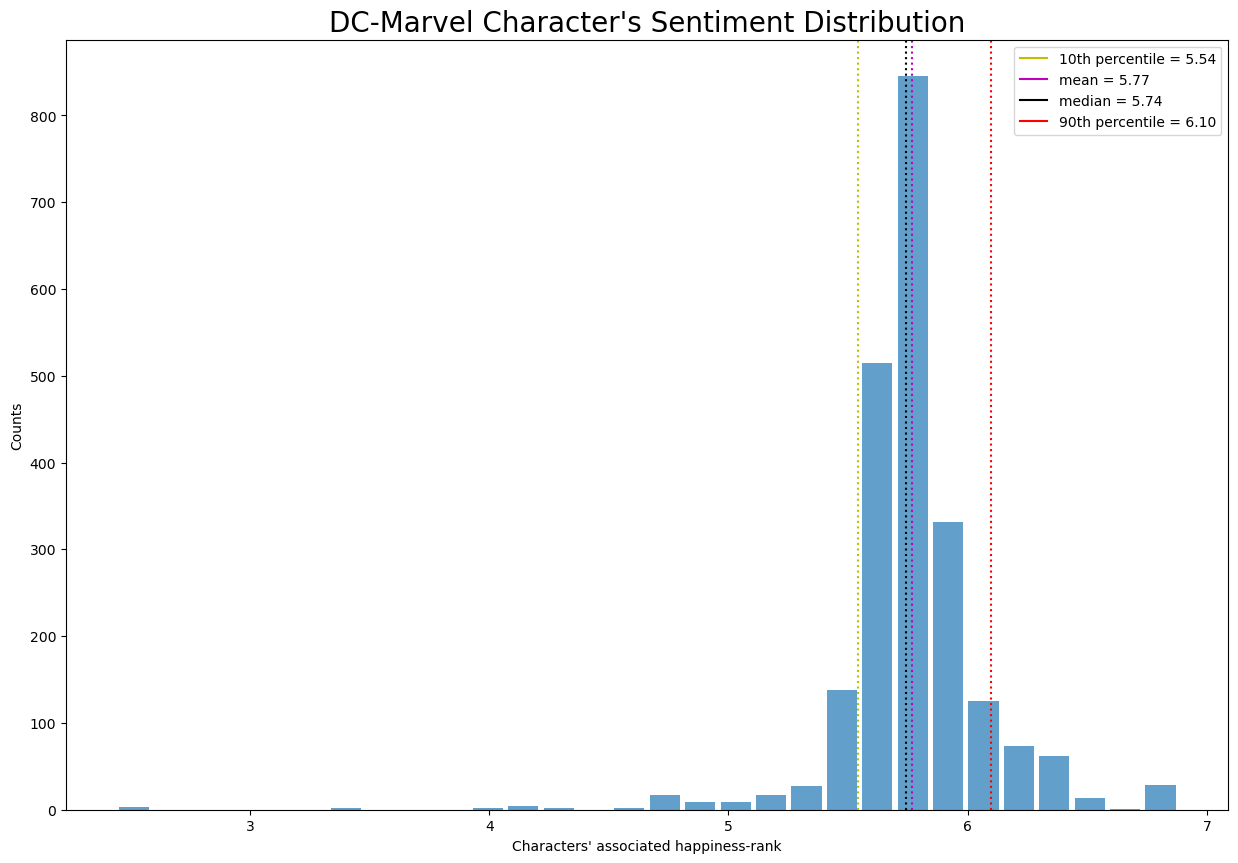

In [10]:
def plot_sentiment(dictionary, title):
    fig, ax = plt.subplots(figsize = (15,10))
    
    num_of_bins = 30
    counts , edges = np.histogram(list(dictionary.values()),bins=num_of_bins)
    
    max_count = np.max(counts)
    spc = list(dictionary.values())
    plt.hist(spc, bins = num_of_bins, alpha=0.7, rwidth=0.85)

    # Calculate percentiles
    percentile_10, median, mean, percentile_90 = np.percentile(spc,10),np.percentile(spc,50),np.mean(spc), np.percentile(spc,90)

    # [percentile, colour]
    percentiles = [[percentile_10, "y"], [mean, "m"], [median, "k"],  [percentile_90, "r"]]

    # Plot the lines with a loop
    for i in percentiles:
        ax.axvline(i[0], color=i[1], linestyle = ":")

    legends = [Line2D([0], [0], marker=None, color=percentiles[0][1], label= f"10th percentile = {percentiles[0][0]:.2f}"),
               Line2D([0], [0], marker=None, color=percentiles[1][1], label= f"mean = {percentiles[1][0]:.2f}"),
               Line2D([0], [0], marker=None, color=percentiles[2][1], label= f"median = {percentiles[2][0]:.2f}"),
               Line2D([0], [0], marker=None, color=percentiles[3][1], label= f"90th percentile = {percentiles[3][0]:.2f}")]

    ax.set_xlabel("Characters' associated happiness-rank")
    ax.set_ylabel("Counts")
    
    plt.title(title, size=20)
    plt.legend(handles = legends, loc=1, fontsize = 10)
    plt.show()
    return mean

average_of_all = plot_sentiment(sentiment_per_character, "DC-Marvel Character's Sentiment Distribution")
               

As expected most of the characters' associated pages fall very close to 5 which the median of the happiness ranking with a small right skew. The distribution is not centered in 5 but in 5.7-5.8 where both the median and average fall into. We can see also that the 10th percentile is also located above 5 whereas the 90th one is located a little above 6. Therefore 80% of our characters's pages are ranked between 5.54 and 6.1 and we can see a few big outliers in the lower rank that reach even the 2 happiness-rank whereas in the right side the maximum value is below 7 (happiness rank ranges from 1 to 9).

In [12]:
good_bad = pd.read_table("../Data/good_bad.txt", delimiter=",")

#create a dictionary with key the CharacterName and value = 10 if good, 1 if bad, 0 if neutral
char_mapping = {"good":10, "bad":1, "neutral":0}
good_bad_dictionary = dict(zip(good_bad["CharacterName"], good_bad["good"]*10+good_bad["bad"]))

In [13]:
#compute happiness-rank or sentiment only for good characters
sentiment_per_good_character = {characterName: sentiment for characterName, sentiment 
                                in sentiment_per_character.items() 
                                if good_bad_dictionary[characterName] == char_mapping["good"]}

#compute happiness-rank or sentiment only for bad characters
sentiment_per_bad_character = {characterName: sentiment for characterName, sentiment 
                                in sentiment_per_character.items() 
                                if good_bad_dictionary[characterName] == char_mapping["bad"]}

In [14]:
average_of_good = plot_sentiment(sentiment_per_good_character,
                                 "'Good' DC-Marvel Character's Sentiment Distribution")

In the happines-rank histogram of the Good characters we can see that it is similar to the one of all the characters , with the values shifted a little bit to the right. There is only one exemption here regarding the 90th percentile which is lower than the one of all the characters which gives an indication that some of the characters with the highest happiness-rank are not probably labeled as good. 

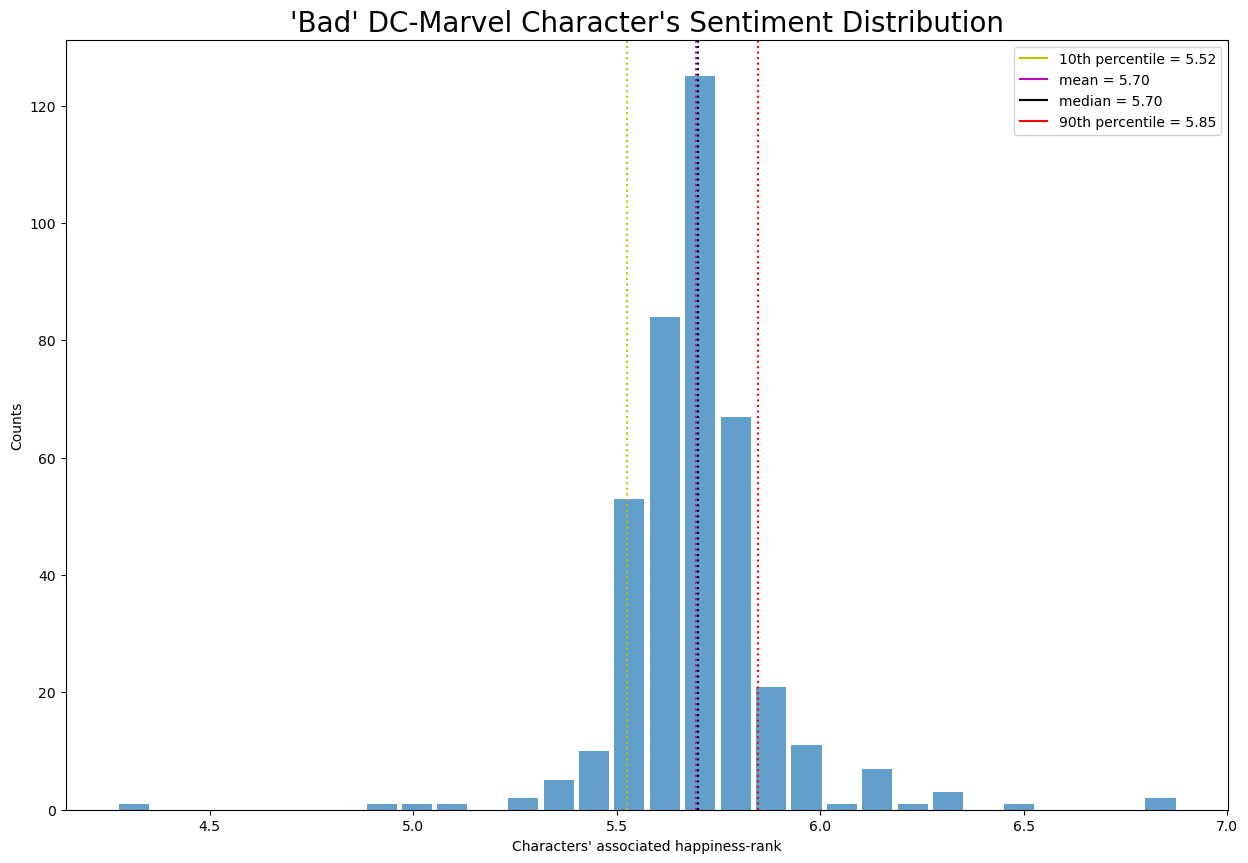

In [15]:
average_of_bad = plot_sentiment(sentiment_per_bad_character,
                               "'Bad' DC-Marvel Character's Sentiment Distribution")

Finally use the label permutation test to investigate the two hypotheses below
* H1: Good characters have a higher averge value for sentiment than a similarly sized set of randomly selected characters.
* H2: Bad characters have a lower average value for sentiment than a similarly sized set of randomly selected characters.

In [16]:
print(f"Average sentiment of all characters: {average_of_all:.2f}")
print(f"Average sentiment of good characters: {average_of_good:.2f}")
print(f"Average sentiment of bad characters: {average_of_bad:.2f}")
print(f"Number of all characters = {len(sentiment_per_character)}")
print(f"Number of good characters = {len(sentiment_per_good_character)}")
print(f"Number of bad characters = {len(sentiment_per_bad_character)}")

Average sentiment of all characters: 5.77
Average sentiment of good characters: 5.79
Average sentiment of bad characters: 5.70
Number of all characters = 2228
Number of good characters = 404
Number of bad characters = 397


Just from the averages we can see that there is an indication that the hypotheses H1 and H2 are true, even though the difference is not high which is expected since the texts are retrieved from wikipedia pages where the tone of the text is generally neutral.
But let's try to convert our intuition to a statistical proof.

#### H1: Good characters have a higher average value for sentiment than a similarly sized set of randomly selected characters.

Let's make a null hypothesis as follows:
* H0: Good characters do **NOT** have a higher average value for sentiment than a similarly sized set of randomly selected characters.

We are going to create 10,000 random samples of 404 characters which is the number of good characters provided by the list and extract their average happiness-rank.
Afterwards we are going to compute the *p-value* which is the percentage of these 10,000 average happiness-ranks that are larger or equal to the average happiness-rank of the good characters computed above.
In this way we will know which is the probability of randomly selected characters to have a higher happiness-rank than the ones that we know that they are the good ones. Of course, if this probability is high then we can probably say that whether the character is good or bad has nothing to do with the happiness-rank of his/her wiki page and therefore not reject the null hypothesis. In contrast, if this probability is low (we are going to define this via the significance level) this means that we can reject the null hypothesis and accept the **H1** hypothesis stated in the assignment.
Finally, we have to set a specific threshold for the value of the *p-value* under which we will consider the null-hypothesis rejected. This is called significance level in the literature and usually the greek alpha is used to symbolize it. We are going to set the significance level for our case to $\alpha = 5\%$.

In [17]:
mean_sentiment_of_random_characters = []
good_characters_number = len(sentiment_per_good_character)
characters = list(sentiment_per_character.keys())
for i in range(2000):
    # get we need same size as the good characters so we ll get the first G characters
    # where G is the number of good characters
    random_characters = np.random.permutation(characters)[:good_characters_number]
    average = sum(sentiment_per_character[char] for char in random_characters)/good_characters_number
    mean_sentiment_of_random_characters.append(average)
    

# plot 
fig, ax = plt.subplots(figsize = (15,10))
plt.hist(mean_sentiment_of_random_characters, bins = 20, alpha=0.7, rwidth=0.85)
ax.axvline(average_of_good, color="k", linestyle = ":")
legends = [Line2D([0], [0], marker=None, color="k", label= f"mean of good = {average_of_good:.2f}")]
ax.set_xlabel("Mean happiness-rank of random sampled  characters")
ax.set_ylabel("Counts")
plt.title("Mean of 'Good' vs Means of 10,000 randomly sampled characters", size=20)
plt.legend(handles = legends, loc=1, fontsize = 10)
plt.show()

p_value = len([x for x in mean_sentiment_of_random_characters if x >= average_of_good])/len(mean_sentiment_of_random_characters)

print(f"p-value = {p_value*100:.2f}%")

p-value = 3.85%


From the plot we can see that the random mean happiness rank of the 10,000 random samples follows an almost perfect normal distribution. The average happiness-rank of the 'good' characters falls in the right part of this distribution with the p-value=3.85%, therefore only 3.85% of the samples had equal or higher happiness-rank than our 'good' characters. Since we set our significance level to 5% and $p-value < \alpha$, we can **reject the null hypothesis** and conclude that the **H1 hypothesis is true**. So, Good characters have a higher average value for sentiment than a similarly sized set of randomly selected characters. 

#### H2: Bad characters have a lower average value for sentiment than a similarly sized set of randomly selected characters.

We are going to follow the same approach for bad characters.

Let's make a null hypothesis as follows whereas the significance level will be the same as defined above and the p-value will be computed as the percentage of the mean values from the random samples that are equal or lower than the average of our bad characters:
* H0: Bad characters do **NOT** have a lower average value for sentiment than a similarly sized set of randomly selected characters.

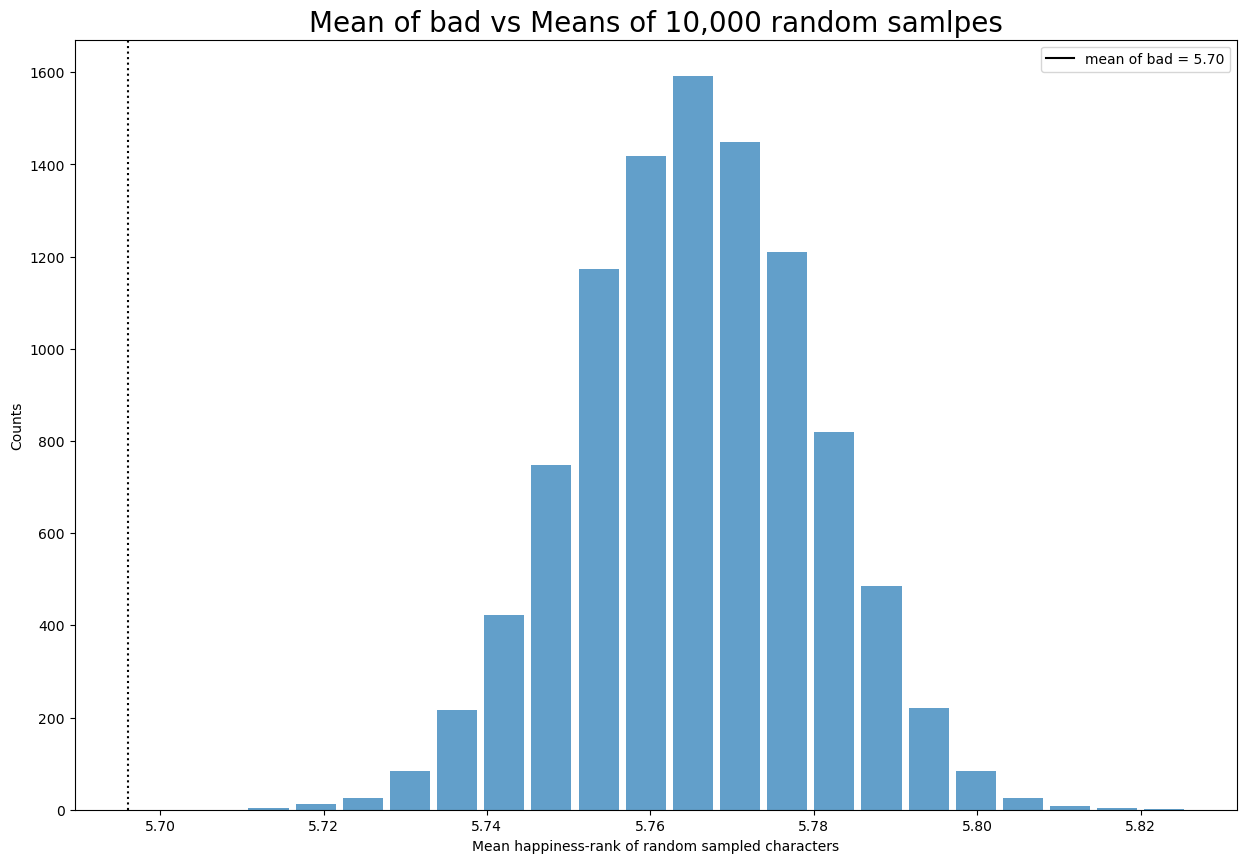

p-value = 0.00%


In [18]:
mean_sentiment_of_random_characters = []
bad_characters_number = len(sentiment_per_bad_character)
characters = list(sentiment_per_character.keys())
for i in range(10000):
    # get we need same size as the good characters so we ll get the first G characters
    # where G is the number of good characters
    random_characters = np.random.permutation(characters)[:bad_characters_number]
    average = sum(sentiment_per_character[char] for char in random_characters)/bad_characters_number
    mean_sentiment_of_random_characters.append(average)

    
    
    
fig, ax = plt.subplots(figsize = (15,10))
plt.hist(mean_sentiment_of_random_characters, bins = 20, alpha=0.7, rwidth=0.85)
ax.axvline(average_of_bad, color="k", linestyle = ":")
legends = [Line2D([0], [0], marker=None, color="k", label= f"mean of bad = {average_of_bad:.2f}")]
ax.set_xlabel("Mean happiness-rank of random samples")
ax.set_ylabel("Counts")
plt.title("Mean of bad vs Means of 10,000 randomly samlped characters", size=20)
plt.legend(handles = legends, loc=1, fontsize = 10)
plt.show()


p_value = len([x for x in mean_sentiment_of_random_characters if x <= average_of_bad])/len(mean_sentiment_of_random_characters)

print(f"p-value = {p_value*100:.2f}%")



In this case we have similar results but the p-value is 0% which makes us even more confident for rejecting the null hypothesis and accepting the **H2** hypothesis. Therefore we can say that yes the Bad characters have a lower average value for sentiment than a similarly sized set of randomly selected characters.

In conclusion, the wiki pages have generally a neutral tone so the differences of happiness rank per document are not high as absolute values. Nevertheless, we were able to prove that characters labeled as good tend to have a higher happiness rank wherea